In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# 1. Load SMS Spam Dataset
def load_sms_data(filepath):
    """ Load the SMS Spam Collection dataset. """
    data = pd.read_csv(filepath, sep='\t', names=['label', 'text'], header=None)
    
    data['label'] = data['label'].map({'ham': 0, 'spam': 1})
    
    return data

# Load dataset
df = load_sms_data(r"C:\Users\HP\Downloads\sms+spam+collection\SMSSpamCollection")

In [5]:
# 2. Text Preprocessing
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(sequences, maxlen=max_len)
y = df['label'].values

In [6]:
# Print preprocessing info
print("\nPreprocessing Info:")
print(f"Vocabulary size: {len(tokenizer.word_index) + 1}")
print(f"Sequence length: {max_len}")
print(f"Total samples: {len(X)}")


Preprocessing Info:
Vocabulary size: 9010
Sequence length: 100
Total samples: 5572


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# 3. Build the RNN Model using Functional API
vocab_size = min(len(tokenizer.word_index) + 1, max_words)

inputs = tf.keras.Input(shape=(max_len,))
x = tf.keras.layers.Embedding(vocab_size, 128)(inputs)
x = tf.keras.layers.SimpleRNN(64, return_sequences=True)(x)
x = tf.keras.layers.SimpleRNN(32)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 100, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 32)                  │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 656,001 (2.50 MB)

 Trainable params: 656,001 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# 4. Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.8021 - loss: 0.4694 - val_accuracy: 0.9496 - val_loss: 0.1597
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9825 - loss: 0.1488 - val_accuracy: 0.9809 - val_loss: 0.0792
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9951 - loss: 0.0945 - val_accuracy: 0.9776 - val_loss: 0.0827
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9984 - loss: 0.0820 - val_accuracy: 0.9798 - val_loss: 0.0869
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9983 - loss: 0.0684 - val_accuracy: 0.9832 - val_loss: 0.0853


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

Model Evaluation:
Test Accuracy: 0.9794

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       966
           1       0.90      0.95      0.93       149

    accuracy                           0.98      1115
   macro avg       0.95      0.97      0.96      1115
weighted avg       0.98      0.98      0.98      1115



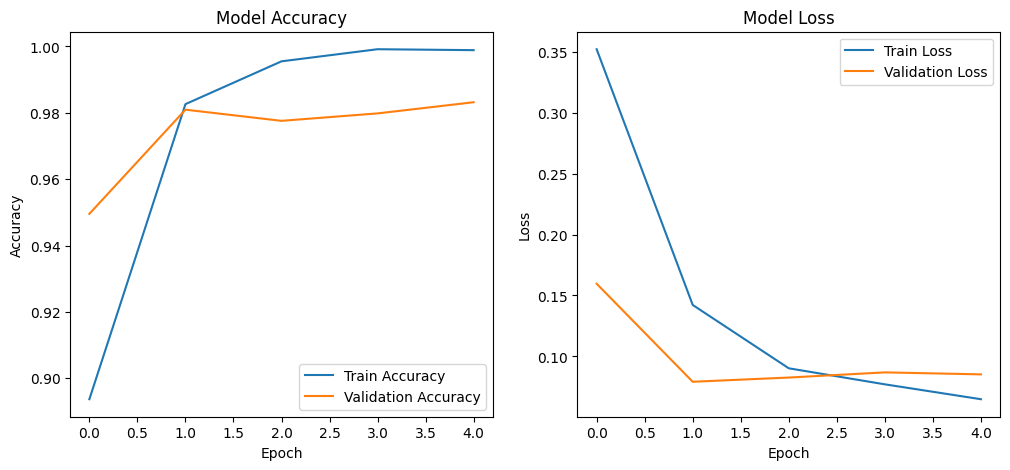

In [11]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("\nModel Evaluation:")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [12]:
# 6. Make Predictions
def predict_sms(text):
    """ Predict whether an SMS is Spam or Ham. """
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_len)
    prediction = model.predict(padded)[0][0]

    spam_label = "Spam" if prediction > 0.5 else "Ham"
    confidence = float(prediction if prediction > 0.5 else 1 - prediction)

    return {
        'text': text,
        'prediction': spam_label,
        'confidence': confidence
    }

# Example Predictions
print(predict_sms("Congratulations! You've won a free lottery. Call now!"))
print(predict_sms("Hey, are we still meeting at 5pm?"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
{'text': "Congratulations! You've won a free lottery. Call now!", 'prediction': 'Spam', 'confidence': 0.9165530204772949}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
{'text': 'Hey, are we still meeting at 5pm?', 'prediction': 'Ham', 'confidence': 0.9888546140864491}



Preprocessing Info:
Vocabulary size: 9010
Sequence length: 100
Total samples: 5572


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 100, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 32)                  │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 656,001 (2.50 MB)

 Trainable params: 656,001 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7711 - loss: 0.4791 - val_accuracy: 0.9473 - val_loss: 0.1717
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9810 - loss: 0.1427 - val_accuracy: 0.9776 - val_loss: 0.0840
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9938 - loss: 0.0742 - val_accuracy: 0.9742 - val_loss: 0.0848
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9926 - loss: 0.0676 - val_accuracy: 0.9742 - val_loss: 0.1058
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9986 - loss: 0.0480 - val_accuracy: 0.9832 - val_loss: 0.0973
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

Model Evaluation:
Test Accuracy: 0.9857

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.98      0.91      0.94       149

    accuracy                           0.99      1115
   macro avg       0.98      0.

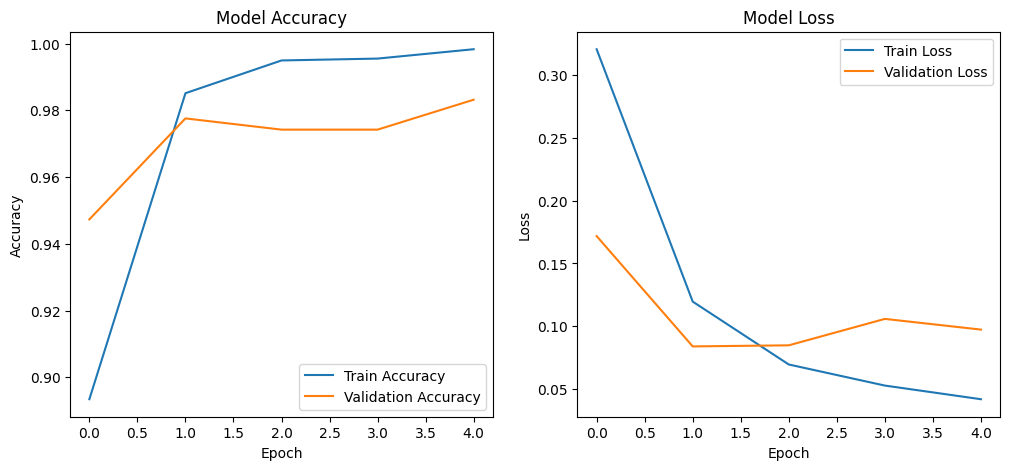

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
{'text': "Congratulations! You've won a free lottery. Call now!", 'prediction': 'Ham', 'confidence': 0.7109865844249725}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
{'text': 'Hey, are we still meeting at 5pm?', 'prediction': 'Ham', 'confidence': 0.9949749750085175}


In [13]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping

# Load SMS Spam Dataset
filepath = r"C:\Users\HP\Downloads\sms+spam+collection\SMSSpamCollection"
data = pd.read_csv(filepath, sep='\t', names=['label', 'text'], header=None)
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

# Text Preprocessing
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
X = pad_sequences(sequences, maxlen=max_len)
y = data['label'].values

# Print preprocessing info
print("\nPreprocessing Info:")
print(f"Vocabulary size: {len(tokenizer.word_index) + 1}")
print(f"Sequence length: {max_len}")
print(f"Total samples: {len(X)}")

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the RNN Model using Functional API
vocab_size = min(len(tokenizer.word_index) + 1, max_words)
inputs = tf.keras.Input(shape=(max_len,))
x = tf.keras.layers.Embedding(vocab_size, 128)(inputs)
x = tf.keras.layers.SimpleRNN(64, return_sequences=True)(x)
x = tf.keras.layers.SimpleRNN(32)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Evaluate Model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("\nModel Evaluation:")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

# Make Predictions
sample_texts = [
    "Congratulations! You've won a free lottery. Call now!",
    "Hey, are we still meeting at 5pm?"
]

for text in sample_texts:
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_len)
    prediction = model.predict(padded)[0][0]
    spam_label = "Spam" if prediction > 0.5 else "Ham"
    confidence = float(prediction if prediction > 0.5 else 1 - prediction)
    print({'text': text, 'prediction': spam_label, 'confidence': confidence})


In [ ]:
8